<a href="https://colab.research.google.com/github/D34dP0oL/4216_Biomedical_DS_and_AI/blob/main/Sheet4/Assignment4_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import math
import pandas as pd

from scipy.stats import poisson, sem, poisson, ttest_ind, shapiro, mannwhitneyu
import scipy.stats as stats # for 'f_oneway'
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

from sklearn import linear_model 
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss

import statsmodels.formula.api as sm # get ANOVA table as R like output
from statsmodels.formula.api import ols # Ordinary Least Squares (OLS) model

import matplotlib.pyplot as plt
from IPython.display import display, HTML
from scipy.cluster.hierarchy import dendrogram, linkage
from mpl_toolkits.mplot3d import Axes3D

## Biomedical Data Science & AI

## Assignment 4

#### Group members:  Fabrice Beaumont, Fatemeh Salehi, Genivika Mann, Helia Salimi, Jonah

---
### Exercise 1 - ANOVA *F*-test and Hierarchical Clustering
Load the leukemia dataset (`leukemia.csv`). It contains gene expression data of 1397 genes from 38
tumor mRNA samples. The expression data is organized in a matrix where rows
correspond to genes and columns to samples. The tumor class of the columns is given in the file `golub.cl`.

In [ ]:
leukemia_db = pd.read_csv('https://raw.githubusercontent.com/D34dP0oL/4216_Biomedical_DS_and_AI/main/Sheet4/leukemia.csv', index_col='gene_name')
leukemia_db.head(4)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38
gene_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AFFX-HUMISGF3A/M97935_3_at,0.45695,-0.09654,0.90325,-0.07194,0.03232,0.09713,-0.11978,0.23381,0.23987,0.44201,-0.39560,-0.62533,0.45181,1.09519,1.09318,0.34300,0.20010,0.38992,0.00641,1.10932,0.21952,-0.72267,0.51690,0.28577,0.61937,0.20085,0.29278,0.26624,-0.43377,-0.10823,-0.29385,0.05067,1.69430,-0.12472,0.04609,0.24347,0.90774,0.46509
AFFX-HUMTFRR/M11507_5_at,-0.56223,0.05358,0.12612,-0.84016,-0.43710,-0.38536,-0.87284,0.07453,-0.36118,-1.21583,-0.40243,-0.19383,-0.82254,-0.97149,-0.91163,-1.12340,-0.22390,-0.13425,-0.77756,-0.73043,-1.06221,-0.13176,-0.02375,-0.62739,-0.15690,-0.77535,-0.84190,0.33921,0.51484,-0.13601,-0.16682,-0.20888,0.25911,-0.21631,0.19129,-0.57687,0.44808,1.19275
AFFX-M27830_M_at,2.40116,1.83222,1.62478,1.59089,0.75700,2.32267,1.64407,2.10957,1.64361,0.32217,1.94740,3.03783,0.57267,1.25632,1.76238,0.87822,0.29212,2.75831,0.94379,0.19046,1.26587,3.06374,3.29195,0.74052,2.98852,1.64597,2.17242,1.54761,1.03327,1.16119,2.25875,1.62017,0.91712,1.50523,2.21754,1.23143,1.87913,2.49036
AFFX-HUMGAPDH/M33197_3_st,0.10806,0.08245,0.48019,-0.29554,-1.25777,0.40172,0.06140,-0.33715,0.22733,-0.57804,0.07233,0.81717,-1.08971,-0.13572,-0.09442,-0.72484,-1.00308,0.18150,-0.40358,-0.64389,-1.02620,0.25894,-0.19135,-1.48332,0.76284,-0.66419,-0.18517,-0.04229,-1.08902,-0.48494,-0.25817,-0.44108,-0.20584,0.29198,-0.01033,-0.08370,-0.11911,0.48378


In [ ]:
leukemia_db.shape

(1397, 38)

In [ ]:
tumor_class_db = pd.read_csv('https://raw.githubusercontent.com/D34dP0oL/4216_Biomedical_DS_and_AI/main/Sheet4/golub.cl.csv', index_col='Unnamed: 0')
tumor_class_db.head(4)

,x
1,0
2,0
3,0
4,0


In [ ]:
### Lets check, that exactly two types of Leukemia (0 and 1) are identified
tumor_class_db.values.T

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [ ]:
tumor_class_db.shape

(38, 1)

#### 1.1. ANOVA *F*-test

##### 1.1.a. What are the assumptions of the ANOVA *F*-test?

To conduct an ANOVA *F*-test one assumes that:
- The variances in the studied groups of samples is the same (**homoscedasticity**)
- A linear model can sufficiently fit the group means (**no heteroscedastic noise**).
- The residuals are normally distributed.
- The samples are randomly and independantly selected for each group.
- All groups of samples are normally distributed.

Sidenote to the foreign words:
- A vector of random variables is **homoscedastic**, if all its random variables have the same finite variance.
- A vector of random variables is "heteroscedastic", if the variability of the random disturbance is different across elements of the vector

(Greek: *hetero* "different", *homo* "equal", *skedasis* "dispersion")

##### 1.1.b. For each gene in the dataset, perform the ANOVA *F*-test (assumptions are already met) to see whether the gene is significantly differentially expressed between the two types of Leukemia.

In [ ]:
### For every gene we conduct an ANOVA F-test with the same null hypothesis:
### Null hypothesis: "The group means of type 0 of leukemia and type 1 of leukemia are equal."
print("The genes that are significantly differentially expressed between the two types of Leukemia are:")
### Store all signifiant genes in a dataframe
signif_genes = pd.DataFrame(columns=['gene_name', 'p-value', 'F-value'])

### From the 'tumor_class_db' get the indices of the two types of leukemia
type_zero_indices = tumor_class_db.index[tumor_class_db['x'] == 0].tolist()
type_one_indices = tumor_class_db.index[tumor_class_db['x'] == 1].tolist()
### Since the 'tumor_class_db' counts the first row as '1' and not '0', we need to shift all indices by '-1'
type_zero_indices = [x - 1 for x in type_zero_indices] 
type_one_indices = [x - 1 for x in type_one_indices] 

### Iterate through all genes
for gene in leukemia_db.index:
    ### Differentiate all columns/ samples that belong to the two different types of leukemia
    gene_expressions_type_zero = leukemia_db.loc[gene].iloc[type_zero_indices].tolist()
    gene_expressions_type_one = leukemia_db.loc[gene].iloc[type_one_indices].tolist()

    ### Stats 'f_oneway' functions takes the two groups as input and returns ANOVA F- and p-value
    fvalue, pvalue = stats.f_oneway(gene_expressions_type_zero, gene_expressions_type_one)
    ### A p-value < 0.05 is significant. Print the name of the gene if that is the case
    if pvalue < 0.05:        
        signif_genes = signif_genes.append({'gene_name' : gene, 'p-value' : pvalue, 'F-value' : fvalue}, ignore_index=True)    

signif_genes

The genes that are significantly differentially expressed between the two types of Leukemia are:


,gene_name,p-value,F-value
0,AFFX-HUMTFRR/M11507_5_at,0.000072,20.086635
1,AB000449_at,0.000850,13.247115
2,AB000468_at,0.039889,4.545975
3,AC000064_cds1_at,0.022949,5.644936
4,AF008937_at,0.011464,7.099773
...,...,...,...
480,U40279_at,0.002999,10.133038
481,X17093_at,0.025641,5.420034
482,Z30643_at,0.044146,4.350522
483,U04241_at,0.044844,4.320449


In [ ]:
nr_all_genes = len(leukemia_db)
nr_signif_genes = len(signif_genes)
signif_percentage = nr_signif_genes / nr_all_genes
print(f"Out of the {nr_all_genes} genes, {nr_signif_genes} are significantly differentially expressed between the two types of Leukemia.")
print(f"That is about {round(signif_percentage*100, 2)}%")

Out of the 1397 genes, 485 are significantly differentially expressed between the two types of Leukemia.
That is about 34.72%


##### 1.1.c. Due to our analysis, we now know which genes are significantly differentially expressed between groups. These will be the best features to use in order to get good cluster separation. Subset only the rows which represent the top 100 most significant genes.

In [ ]:
### The genes are more significant, the lower their p-value is. 
### Thus return the 100 genes with the lowest p-value:
most_signif_100_genes = signif_genes.nsmallest(100, 'p-value')
most_signif_100_genes

,gene_name,p-value,F-value
155,M63138_at,2.366804e-08,50.530583
243,U50136_rna1_at,2.519519e-08,50.235874
478,M31523_at,2.713676e-08,49.887317
124,M16038_at,4.802350e-08,47.255323
173,M92287_at,6.046048e-08,46.217096
...,...,...,...
137,M28209_at,2.294286e-04,16.754857
169,M83221_at,2.310119e-04,16.735696
219,U30521_at,2.363345e-04,16.672289
422,HG627-HT5097_s_at,2.443697e-04,16.579380


#### 1.2. Plot 2 dendrograms using the 100 selected genes:

In [ ]:
### See this awesome website for further information:
### https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

##### 1.2.a. One for a single linkage approach and another one for ward approach.

In [ ]:
most_signif_100_genes_db = leukemia_db.loc[most_signif_100_genes['gene_name']]
most_signif_100_genes_db.head(4)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38
gene_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
M63138_at,0.98318,1.39165,1.46391,0.86954,0.92723,1.49335,1.71610,1.34453,1.38809,1.47143,1.15281,1.75560,0.46085,1.51090,1.26225,1.39635,1.59592,0.68372,1.24144,0.93333,0.49434,1.01094,1.27365,0.95373,1.17502,1.11362,1.65242,1.97190,1.93217,2.39638,2.16979,2.40208,1.38017,2.33999,2.33015,2.60321,2.31917,1.50779
U50136_rna1_at,0.77407,0.69785,0.85670,0.69715,0.63730,0.76063,0.83617,1.19658,0.45291,1.05127,0.37929,0.92141,0.36598,0.59186,0.05042,0.60024,0.89360,0.89230,1.21479,0.10098,0.17052,0.87792,0.71801,0.57714,1.02880,0.64994,1.17794,1.11343,1.92742,1.70779,1.76434,1.44715,0.77720,1.56749,1.74375,1.65866,1.43275,1.51216
M31523_at,0.92234,0.54933,0.10862,1.21964,0.96513,0.69793,0.72464,1.32339,0.79254,0.15163,0.36618,0.47953,1.27253,0.37879,1.46878,1.12782,0.36998,1.17631,1.15058,1.49879,1.96569,-0.16915,0.51035,1.24043,0.33312,1.44738,1.00982,-0.28526,-0.13281,-0.54233,-0.06494,0.25829,-0.87699,-0.33927,0.08948,-1.20703,-0.79439,-0.40721
M16038_at,-0.26342,0.22701,-1.39460,0.62578,0.35737,-0.19119,-0.27313,-0.55534,-0.62212,-0.88031,-1.28137,0.31220,-0.44829,0.23799,0.49646,-0.39452,-0.15118,0.41887,-1.24482,-0.12873,0.31237,-0.29898,-1.20963,0.05444,-1.25268,-0.36578,0.25452,0.31019,1.30495,1.41996,0.82319,1.49690,1.50992,1.23706,0.70736,1.34766,1.38402,0.54227


In [ ]:
### The 'linkage' function returns a matrix which rows denote an cluster merging-iteration
### Every row stores the indixes of the merged clusters, their distance and the number of samples in the resulting cluster

### Singel linkage approach
dendogram_single = linkage(most_signif_100_genes_db, 'single')
### Ward approach
dendogram_ward = linkage(most_signif_100_genes_db, 'ward')

In [ ]:
def plot_dendogram(data, name=None, x_label=None, y_label=None, truncate_nr=None):
    plt.figure(figsize=(25, 10))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    if name is not None:
        plt.title(name)
    if x_label is not None:
        plt.xlabel(x_label)
    if y_label is not None:
        plt.ylabel(y_label)

    dendrogram(
        data,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=8.,  # font size for the x axis labels
    )
    if truncate_nr is not None:
        dendrogram(
            data,
            truncate_mode='lastp',  # show only the last p merged clusters
            p=truncate_nr,  # show only the last p merged clusters
            show_leaf_counts=False,  # otherwise numbers in brackets are counts
            leaf_rotation=90.,
            leaf_font_size=12.,
            show_contracted=True,  # to get a distribution impression in truncated branches
        )
    
    plt.show()

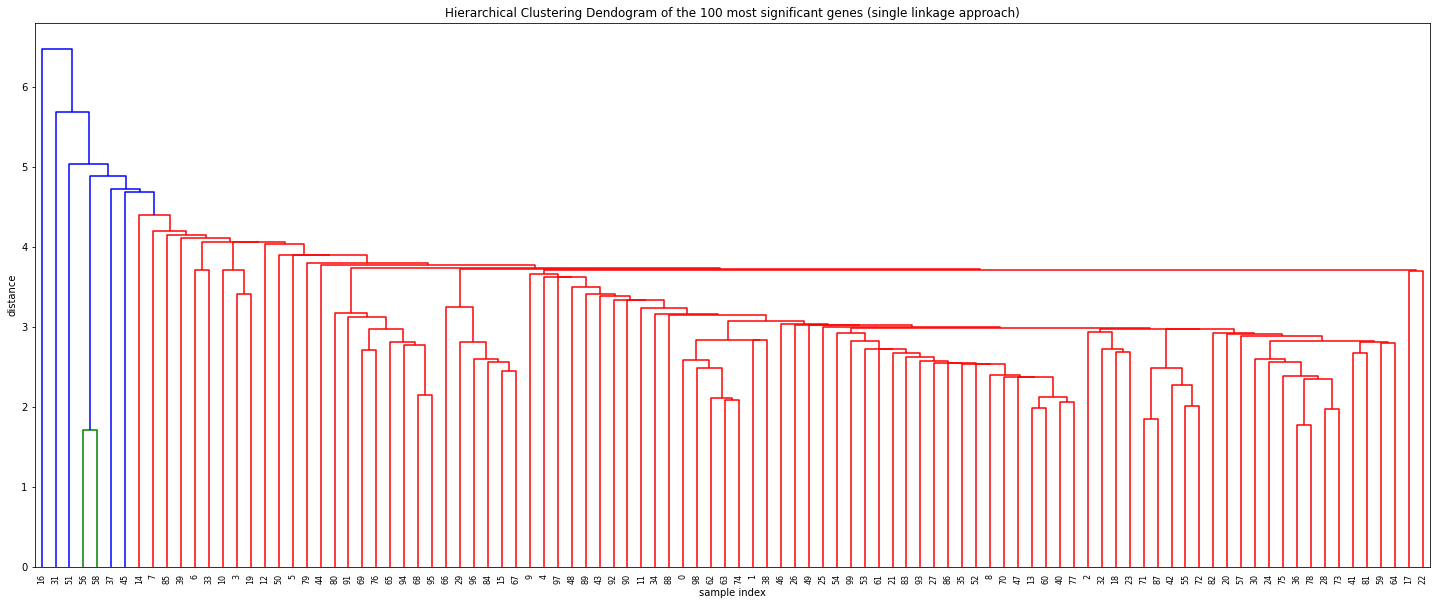

In [ ]:
plot_dendogram(dendogram_single, "Hierarchical Clustering Dendogram of the 100 most significant genes (single linkage approach)")

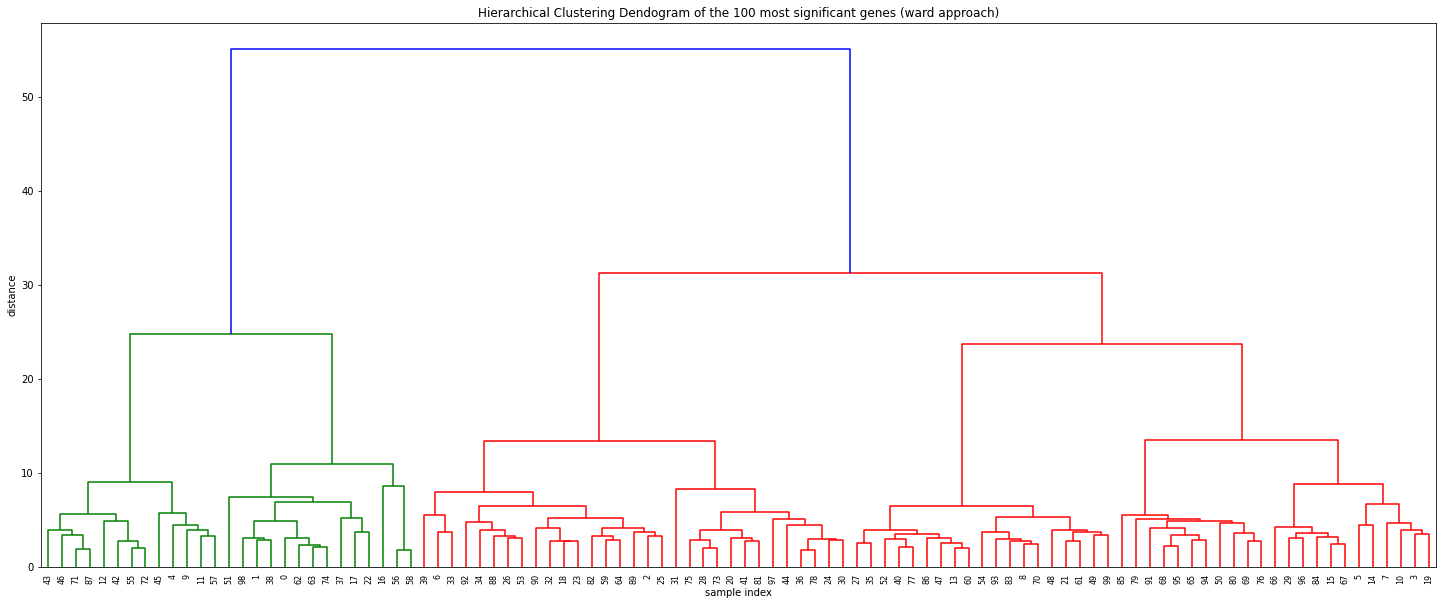

In [ ]:
plot_dendogram(dendogram_ward, "Hierarchical Clustering Dendogram of the 100 most significant genes (ward approach)")

##### 1.2.b. Which method would you recommend based on the dendrograms for a clustering? Why?

The dendogram created using the **ward approach is better**, since the hierarchical tree is more equally distributed/merged. With the single linkage approach, a lot of clusters are successively growing by merging with a single gene.

The Single linkage method and Ward criterion method vary on the basis of the metric used to define the proximity between two clusters.We would prefer to obtain clusters which are more well separated from each other and where each cluster must contain data points which are similar to other data points within their cluster. Based on the dendrograms, the Ward method for clustering has created clusters which are more well separated as shown in dendrogram.


##### 1.2.c. Familiarize yourself with **Cophenetic correlation coefficient** and calculate the cophenetic correlation distance for both single linkage as well as ward.

The Cophenetic correlation coefficien indicates how well the dendograms preserve the actual distances  of the data. The closer the coefficient is to one, the better the preservation.

In [ ]:
c_single, coph_dists_single = cophenet(dendogram_single, pdist(most_signif_100_genes_db))
c_ward, coph_dists_ward = cophenet(dendogram_ward, pdist(most_signif_100_genes_db))
print(f"The Cophenetic correlation coefficient for the ward approach is           ~{round(c_ward,2)} \t({c_ward})")
print(f"The Cophenetic correlation coefficient for the single linkage approach is ~{round(c_single,2)} \t({c_single})")

The Cophenetic correlation coefficient for the ward approach is           ~0.71 	(0.7122409337749579)
The Cophenetic correlation coefficient for the single linkage approach is ~0.29 	(0.29202720217881184)


##### 1.2.d. Based on the cophenetic correlation distance, which clustering method performed better?

In [ ]:
if c_ward < c_single:
    name = "single linkage"    
else:
    name = "ward"

print(f"The {name} approach is better, since its Cophenetic correlation coefficient (preservation of the original distances) is higher.")

The ward approach is better, since its Cophenetic correlation coefficient (preservation of the original distances) is higher.


#### 1.3. Apply two Agglomerative Clustering.

##### 1.3.a. One using single linkage and one using **ward method**.

In [ ]:
### Single linkage approach
agglomerative_single = AgglomerativeClustering(linkage='single').fit(most_signif_100_genes_db)
### Ward approach
agglomerative_ward = AgglomerativeClustering(linkage='ward').fit(most_signif_100_genes_db)

Visualizing this data is a bit tricky, since the feature vectors have 38 dimensions (number of samples). To still get an idea, that the agglomerative clustering was reasonable, we define a function that reduces the data to three dimensions and then display the agglomerative clustering as a heat map on this representation.

In [ ]:
def pca_scatter_plt(dataframe, colours=None, name=None):
    X = dataframe.values
    # Project data down to 3D
    pca = PCA(n_components=3)
    X_three_d = pca.fit_transform(X)

    # Now plot in 3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    plt.title(f"Agglomerative Clustering")
    if name is not None:
        plt.title(f"Agglomerative Clustering using {name} method")

    x = X_three_d[:,0]
    y = X_three_d[:,1]
    z = X_three_d[:,2]
    
    img = ax.scatter(x, y, z)
    if colours is not None:
        img = ax.scatter(x, y, z, c=colours)
    plt.show()

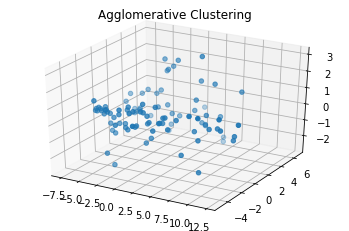

In [ ]:
pca_scatter_plt(most_signif_100_genes_db)

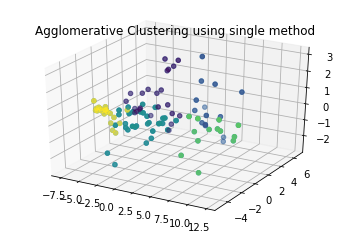

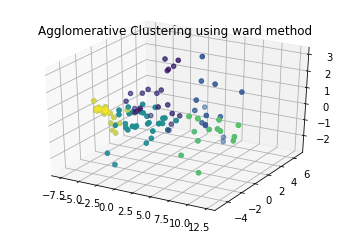

In [ ]:
for linkage in ['single', 'ward']:
    agglo_clustering = AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=5).fit(most_signif_100_genes_db)
    
    pca_scatter_plt(most_signif_100_genes_db, agglo_clustering.labels_, linkage)

---
### Exercise 2 - PCA
Using the same leukemia dataset generate the feature matrix (transposed leukemia dataset) and the class labels (`golub.cl.csv`).

In [55]:
feature_matrix = leukemia_db.T
feature_matrix.shape

(38, 1397)

#### 2.1. Perform a PCA on the feature matrix and answer the following questions:

##### 2.1.a. How many PC’s do you need to explain at least 95% of the variance?

In [47]:
# create PCA model and fit model to feature_matix
pca = PCA()
gene_pca_result = pca.fit_transform(feature_matrix)
gene_pca_result

array([[-1.66097653e+00, -5.55344514e+00, -4.08752470e+00, ...,
         1.20513583e+00, -3.42846960e-01,  4.87727279e-15],
       [-1.28644441e+00,  4.63851571e+00,  3.39181451e+00, ...,
         5.72539341e-01,  4.30725929e-03,  4.87727279e-15],
       [-1.55187216e+00, -9.50775135e+00,  7.04167677e+00, ...,
        -2.32465774e+00,  1.45084711e+00,  4.87727279e-15],
       ...,
       [ 1.07419931e+01,  7.37587603e+00,  6.36773890e-01, ...,
         8.76250582e-01, -9.43719417e-02,  4.87727279e-15],
       [ 1.27538160e+01,  9.09981623e+00,  1.31807025e+00, ...,
        -2.17416840e-01, -2.62355679e+00,  4.87727279e-15],
       [ 9.96351945e+00,  3.02486006e+00, -2.81442388e-01, ...,
         1.18180814e+00,  5.45101470e-01,  4.87727279e-15]])

In [48]:
# using pca.explained_variance_ratio to obtain the percentage of variance explained by each PCA
sum = 0
component_index = 0

while sum < 0.95:
    print(f'Principal Component {component_index + 1} explains {pca.explained_variance_ratio_[component_index]*100}% variance')
    sum += pca.explained_variance_ratio_[component_index]
    
    component_index = component_index + 1
print( f'95% of the variance in data can be explained by {component_index} PC\'s')

Principal Component 1 explains 17.558612682725624% variance
Principal Component 2 explains 10.206709882300274% variance
Principal Component 3 explains 7.512126490725313% variance
Principal Component 4 explains 5.53430803775283% variance
Principal Component 5 explains 4.72648843423406% variance
Principal Component 6 explains 4.0404955387139685% variance
Principal Component 7 explains 3.751505085446695% variance
Principal Component 8 explains 3.526663588068172% variance
Principal Component 9 explains 3.2900888928230563% variance
Principal Component 10 explains 2.741355536844273% variance
Principal Component 11 explains 2.5192547475814777% variance
Principal Component 12 explains 2.229797062740382% variance
Principal Component 13 explains 2.1088252443268454% variance
Principal Component 14 explains 2.0291555518988775% variance
Principal Component 15 explains 1.873430631546385% variance
Principal Component 16 explains 1.8445750530299752% variance
Principal Component 17 explains 1.778797004

In [49]:
pca = PCA(n_components=31)
pcs = pca.fit_transform(feature_matrix)

np.sum(pca.explained_variance_ratio_)


0.9501503925611416

We need at least 31 PC's to explain at least 95% of the variance.

##### 2.1.b. Make a scatterplot of the projections on the first two PC‘s with the colouring corresponding to the class labels.

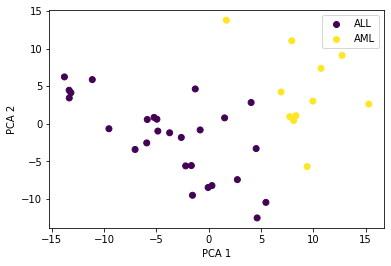

In [51]:
classes = ['ALL', 'AML']
result_df = pd.DataFrame(np.hstack([pcs[:,:2],tumor_class_db]), columns = ['pc 1', 'pc 2', 'label'])

scatter = plt.scatter(result_df['pc 1'], result_df['pc 2'], c=result_df['label'])
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.show()

##### 2.1.c. Based on the scatterplot answer the following questions:

- Given the plot, do you think PCA might be a good choice? Why?

As seen in the plot the first two principal components split the data into two distinct regions and is therefore a good tool in this case.
- The large number of features of the dataset are reduced to just two Principal Components which are able to differentiate between the two classes. The dataset contained numerous features as compared to datapoints hence it is is reasonable to apply a dimensionality reduction technique such as PCA.
- All irrelevant information has been supressed and reduced to principal components which are not linearly correlated.
- The first two PCA's are able to separate the data points of the two classes properly in the plot.
- We are also able to plot the data points and view a visual representation because we have reduced the dimensions of the data.

- Do you think n=2 components are a good choice? Why?

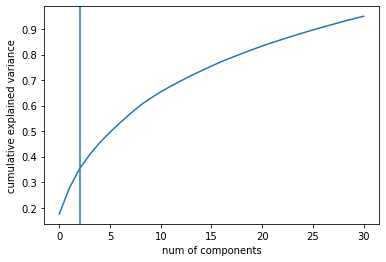

In [46]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('num of components')
plt.ylabel('cumulative explained variance')
plt.axvline(x=2)

In the plot we can see that the slope is still very steep at more than two principal components. I'd recommend to use at least 7 components in this case because at around 7-8 components the slope starts to decrease.
Also, since the two components are only able to explain around 27% of variance as indicated by the explained variance ratio it would be better to use more components. However these two components are able to separate the two classes well hence they are a good choice for dimensionality reduction in the problem.

#### 2.2. Inform yourself regarding decorrelation of features in a dataset.

##### 2.2.a. Identify the correlated features in the dataset.


In [59]:
# calculating pairwise feature correlation in matrix
correlated_features = set()
corr_matrix = feature_matrix.corr().abs()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if(corr_matrix.iloc[i,j]>0.8):
            correlated_features.add(corr_matrix.columns[i])
print(correlated_features)

{'X83492_at', 'X51345_at', 'M31523_at', 'D14658_at', 'X70394_at', 'U65928_at', 'U39905_at', 'X97302_at', 'L25931_s_at', 'U04241_at', 'D14657_at', 'X62654_rna1_at', 'X03068_f_at', 'U89336_cds3_at', 'Z71460_at', 'M55422_at', 'M37583_at', 'X79981_at', 'Z47055_s_at', 'M21259_at', 'HG4535-HT4940_s_at', 'Z22551_at', 'U50939_at', 'HG1751-HT1768_at', 'L27706_at', 'U13695_at', 'L00389_f_at', 'Z29064_at', 'Z15115_at', 'X68277_at', 'U25750_at', 'HG3076-HT3238_s_at', 'L11672_r_at', 'L40391_at', 'L36531_at', 'M54915_s_at', 'X54941_at', 'Z80783_at', 'L05187_at', 'U59736_at', 'L37112_at', 'U41767_s_at', 'Z35102_at', 'X14008_rna1_f_at', 'X85373_at', 'U90907_at', 'X68985_s_at', 'U20998_at', 'X90846_at', 'U82311_at', 'U79254_at', 'U72206_at', 'X13444_at', 'X74801_at', 'S82297_at', 'U52112_rna5_at', 'U03398_at', 'L42572_at', 'X68560_at', 'L47276_s_at', 'HG627-HT5097_s_at', 'Y14140_at', 'U68063_at', 'X89101_s_at', 'U72936_s_at', 'S40719_s_at', 'L43631_at', 'L20298_at', 'U19948_at', 'M97935_s_at', 'X82895_

##### 2.2.b. Decorrelate the correlated datasets.

In [60]:
# METHOD 1 - dropping correlated features of dataset
decorrelated_dataset = feature_matrix.drop(labels=correlated_features, axis=1)
decorrelated_dataset

# METHOD 2 - It is also possible to prerform PCA as we have done in exercise 2.1.a to obtain PCAs which are not correlated

gene_name,AFFX-HUMISGF3A/M97935_3_at,AFFX-HUMTFRR/M11507_5_at,AFFX-M27830_M_at,AFFX-HUMGAPDH/M33197_3_st,AFFX-HSAC07/X00351_M_st,A28102_at,AB000449_at,AB000468_at,AB001106_at,AB001325_at,AB002382_at,AB003177_at,AC000061_cds2_at,AC000064_cds1_at,AF000560_at,AF007875_at,AF008937_at,AF015913_at,AJ000480_at,D00596_at,D00632_at,D00726_at,D00760_at,D00761_at,D00762_at,D00763_at,D10511_at,D10523_at,D11086_at,D13370_at,D13435_at,D13627_at,D13630_at,D13640_at,D13897_rna2_at,D13900_at,D13988_at,D14043_at,D14661_at,D14662_at,...,M31932_at,M99439_at,U19765_at,U25975_at,U28014_at,U40279_at,U92027_at,X01703_at,X17093_at,X69115_at,X69654_at,X98296_at,Z30643_at,Z80787_at,L08904_at,M25296_at,M25667_at,U01337_at,U09587_at,X12953_at,Y00477_at,M34516_at,U88898_r_at,D38437_f_at,L02326_f_at,L42601_f_at,L42611_f_at,L76568_xpt3_f_at,M60750_f_at,U10690_f_at,X13930_f_at,X67491_f_at,L41268_f_at,S80905_f_at,D64015_at,L78833_cds4_at,M93143_at,U58516_at,X83863_at,Z17240_at
V1,0.45695,-0.56223,2.40116,0.10806,-0.33978,-1.07755,-1.45769,-0.23113,-0.28904,0.79436,0.11981,0.17642,-0.18126,-0.53809,-0.05607,-0.57631,-0.33158,-0.01850,0.56392,1.20843,-0.84642,-0.52794,0.39595,0.26747,0.26176,0.92513,-1.45769,-0.14499,1.03841,1.31844,-0.16295,0.19505,0.29270,0.27736,0.12646,1.11918,1.20689,0.80315,-0.09735,0.01200,...,1.09284,0.62763,-1.02994,0.18578,-0.82294,-1.45769,-0.26342,1.55469,2.31220,0.02503,3.12262,-0.35083,1.11067,-0.80006,-0.64631,-0.10583,-0.20231,0.96668,1.03532,0.02133,0.52605,2.42050,1.24115,-1.29723,0.32531,-0.10796,0.90755,0.65604,0.82204,-0.62737,0.03423,-0.95744,-0.18822,0.33856,-0.69342,-0.30476,-0.21661,0.04695,0.45231,-0.35920
V2,-0.09654,0.05358,1.83222,0.08245,-0.12775,-0.53800,-0.92959,-0.58643,-0.10064,0.59074,-0.71643,0.42573,-0.70011,0.18488,-1.39420,-0.25511,-0.05655,0.20837,0.38868,1.50045,-0.46068,-0.09858,0.18190,0.95507,0.42686,1.38362,-1.39420,0.25081,1.79074,1.13094,-1.39420,0.62399,0.60010,-0.84949,-0.29514,1.15415,0.51105,0.47211,0.39809,0.81337,...,1.06516,-0.37544,-0.04684,-0.08234,0.07742,-0.39242,-1.03519,2.03017,0.83076,-0.39528,2.08474,-0.08033,0.97785,-0.02205,0.18933,-0.82588,-0.69607,0.73139,1.17336,-1.02346,0.39575,1.58641,0.46887,-0.61168,0.60196,0.06217,0.55425,-0.55499,1.20683,-0.18011,-0.08234,-1.01189,-0.91917,-1.39420,-0.80743,-0.72056,-0.65287,0.48704,0.42686,-0.43633
V3,0.90325,0.12612,1.62478,0.48019,0.32201,-1.46227,-0.33853,-0.33121,0.11741,1.13748,-0.12058,0.60000,0.18340,-0.12633,-0.29785,-0.24345,-0.50522,0.41925,0.60420,1.76610,0.24225,0.16977,1.06810,0.69792,0.66099,1.42787,-1.10579,0.60754,1.48385,1.37439,-0.36589,0.87229,0.66099,-0.18809,0.20873,1.22360,1.20264,0.42749,0.00562,0.10419,...,1.13290,0.49169,-0.73381,0.16839,-0.12058,-0.36085,-0.03505,1.33074,0.39832,0.13187,2.56446,-1.12355,0.93488,-0.78520,-0.85286,-0.67803,0.05707,0.51333,0.91686,-0.73381,0.65468,-1.46227,0.85355,-0.46190,0.38552,-0.10542,0.78123,-0.17579,0.47243,-0.28164,0.23207,-0.94549,-0.32879,0.37034,-0.51414,-0.11296,0.27332,0.72170,0.67579,0.34031
V4,-0.07194,-0.84016,1.59089,-0.29554,0.12330,0.07237,-0.46145,-0.48925,-0.52887,0.82368,0.12513,0.35192,0.49696,-0.07420,-0.30130,-0.20273,-0.09947,0.40643,0.76811,1.09403,0.18201,-0.43113,0.52370,0.64704,0.50799,1.07890,-0.17963,0.31972,1.33192,1.66758,-0.04300,0.41589,0.26766,0.72946,0.00403,1.54724,1.72492,0.73426,-0.22642,0.47071,...,0.95277,0.27081,-0.80494,-0.01280,-0.23984,-0.66314,-0.10883,0.84859,0.96408,-0.68461,2.81420,-0.13506,1.05812,-0.39855,0.31823,-0.96033,-0.72454,0.51043,0.84349,-0.58967,0.53205,1.06353,1.14668,-0.31000,1.56715,-0.03863,1.21793,-0.10648,0.89328,-0.65468,-0.16453,-0.30130,0.01439,-0.18727,-1.17554,-0.25346,-0.35475,0.58403,0.31524,-0.90930
V5,0.03232,-0.43710,0.75700,-1.25777,-1.42668,-1.27334,-0.37552,0.15938,0.18413,0.06622,0.08995,0.70560,-0.53083,-0.14934,-0.69202,-0.16820,-0.05406,0.95243,0.28434,1.53252,-1.39034,-0.77990,0.83358,1.03334,0.87697,1.38323,0.38792,0.46559,1.08647,1.79990,0.03423,1.27093,0.48344,0.87234,-0.75265,1.53745,1.88183,1.

##### 2.2.c. What is the purpose of carrying out decorrelation of features in a dataset?

- Correlated features convey redundant information to models prepared for the dataset hence they must be decorrelated.
- Removal of correlated features also helps reduce the dimensions of the dataset
- Linear models such as linear regression and logistic regression do not perform well when correlation is present in features.

---
### Exercise 3 - Logistic Regression

#### 3.1. Using the reduced dataset from exercise 2.1, carry out the following tasks:

##### 3.1.a Generate a logistic regression model on the first 5 PCs of the reduced dataset using 80% of the total samples.

In [61]:
# preparing dataset with first 5 PCAs
column_names = ['pca_%i' % i for i in range(5)]
gene_pca_dataframe = pd.DataFrame(gene_pca_result[:, 0:5], columns = column_names, index= feature_matrix.index)

# preparing class label
y = tumor_class_db

# splitting into training and testing data
X_train, X_test, y_train, y_test = train_test_split(gene_pca_dataframe, y, test_size = 0.2)

In [62]:
# generating logistic regression model
logistic_regression_model = LogisticRegression().fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


##### 3.1.b. Predict the labels for the remaining 20% of the samples and calculate your model’s accuracy

In [63]:
# predicting labels for test data
y_predicted = logistic_regression_model.predict(X_test)
y_predicted

array([0, 0, 0, 0, 0, 0, 1, 0])

In [64]:
# accuracy of model
mean_accuracy = logistic_regression_model.score(X_test, y_test)
print(f'Logistic Regression model has a mean accuracy of {mean_accuracy}')

Logistic Regression model has a mean accuracy of 1.0


#### 3.2. Inform yourself about **Brier’s Score**. How can it be used to evaluate the performance of your model? Show by implementation.

Brier's Score calculates mean squared error between predicted probabilities and expected values. It summarises the magnitude of error in the probability forecasts. The score is between 0.0 and 1.0, with 0.0 being the best score.
**This is not working.Not sure why?**

In [65]:
# prediction probabilities
prediction_probabilities = logistic_regression_model.predict_proba(X_test)
# prediction_probabilities
brier_score_loss_result = brier_score_loss(y_test.to_numpy(), prediction_probabilities)

ValueError: ignored

#### 3.3. Assess the significance of your variables using the likelihood ratio test.